<a href="https://colab.research.google.com/github/jinhyung426/deeplearning.ai/blob/main/tf_chap4_Time_Series_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tensorflow

## Part 4. Sequences, Time Series and Prediction

## (2) Predicting Simulation Data

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Generating Time Series

- **Trend** : linearity (slope 값 곱셈) 적용
- **Seasonality** : np.where, np.cos, np.exp 이용해서 pattern 적용
- **Noise** : np.random.RandomState(seed).randn(n) 이용해서 noise 더하기

# np.where 사용

(1) List에 **조건문을 적용**하고 싶을 때 사용하기 좋음

(2) List에서 **특정 데이터(들)만을 찾아서 바꾸고 싶을 때** 사용하기 좋음

(3) for문보다 빠름


In [2]:
lst = np.array([1, 2, 3, 4, 0.1, 0.2, 0.3])
np.where(lst < 1)


(array([4, 5, 6]),)

In [3]:
# (1) List에 조건문을 적용할 때 사용하기 좋음

lst[np.where(lst < 1)]

array([0.1, 0.2, 0.3])

In [4]:
lst[np.where(lst % 2 == 0)]

array([2., 4.])

In [5]:
# (2) 특정 데이터를 찾아서 바꾸는 데 사용하기 좋음 - for 문보다 빠름

np.where(lst >= 1, lst*0.2, lst)  # lst에서 1 이상인 값들은 0.2를 곱해주고, 아닌 값들은 그대로 두라는 의미


array([0.2, 0.4, 0.6, 0.8, 0.1, 0.2, 0.3])

# np.exp

In [6]:
np.exp(1)

2.718281828459045

In [7]:
def trend(time, slope=0):
  return time * slope

def seasonal_pattern(season_time):
  """Just an arbitrary pattern, you can change it if you wish"""
  # season_time이 0.4보다 작은 경우, 2pi를 곱해준 후 cos 값을 취해주고, 그러지 않을 경우 3배를 해준 후 자연상수 e의 exponential을 취해서 역수를 취해준다
  return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi), 1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
  rnd = np.random.RandomState(seed)
  return rnd.randn(len(time)) * noise_level

In [8]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

In [9]:
# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)

# Update with noise
series += noise(time, noise_level, seed=42)

In [10]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

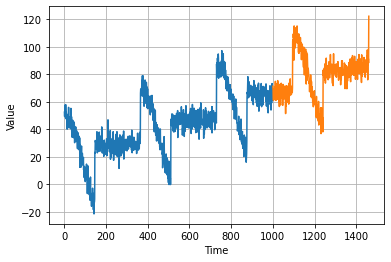

In [13]:
def plot_series(time, series, format="-", start=0, end=None):
	plt.plot(time[start:end], series[start:end])
	plt.xlabel("Time")
	plt.ylabel("Value")
	plt.grid(True)
 

plot_series(time_train, x_train)
plot_series(time_valid, x_valid)

In [14]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)  # + 1 for label
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1:]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [16]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Finding Optimal Learning Rate - LearningRateScheduler

- tf.keras.callbacks.LearningRateScheduler()
- Before we run the model for high epochs, 
use a **LearningRateScheduler callback** to **adjust the lr per epoch and eventually find the best learning rate with the minimum loss**

- Use **plt.semilogx** to plot learning rate and loss together
- **After identifying the optimal learning rate, initialize and compile a new model with the same structure** so that it doesn't retrain the previous model (which it's loss would have diverged at the end due to high learning rate)

In [19]:
# Layer별로 변수 지정 - good for getting weights, debugging

layer_0 = tf.keras.layers.Dense(10, input_shape=[window_size], activation='relu')
layer_1 = tf.keras.layers.Dense(10, activation="relu")
layer_2 = tf.keras.layers.Dense(1)

model = tf.keras.models.Sequential([layer_0, layer_1, layer_2])

In [21]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20)
)

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9))
history = model.fit(dataset, epochs=100, verbose=1, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 0s 1ms/step - loss: 100.0187
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 94.7875
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 111.2150
Epoch 4/100
31/31 [==============================] - 0s 2ms/step - loss: 110.5594
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 114.0526
Epoch 6/100
31/31 [==============================] - 0s 2ms/step - loss: 90.4758
Epoch 7/100
31/31 [==============================] - 0s 2ms/step - loss: 103.2047
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 111.4991
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 109.1556
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 105.4480
Epoch 11/100
31/31 [==============================] - 0s 1ms/step - loss: 101.1058
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 124.7967
Epoch 13/100
31

(1e-08, 0.001, 0.0, 300.0)

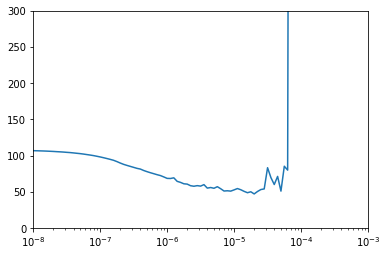

In [22]:
learning_rates = 1e-8 * (10 ** (np.arange(100) / 20))
plt.semilogx(learning_rates, history.history["loss"])
plt.axis([1e-8, 1e-3, 0, 300])

In [28]:
# The optimal learning rate is about 8e-4. Therefore, we train again with the optimal learning rate

In [25]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(10, activation="relu", input_shape=[window_size]),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1)
])

In [26]:
optimizer = tf.keras.optimizers.SGD(lr=8e-6, momentum=0.9)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(dataset, epochs=500, verbose=1)

Epoch 1/500
31/31 [==============================] - 0s 2ms/step - loss: 617.5005
Epoch 2/500
31/31 [==============================] - 0s 2ms/step - loss: 94.4625
Epoch 3/500
31/31 [==============================] - 0s 3ms/step - loss: 61.9960
Epoch 4/500
31/31 [==============================] - 0s 3ms/step - loss: 55.9564
Epoch 5/500
31/31 [==============================] - 0s 2ms/step - loss: 59.8747
Epoch 6/500
31/31 [==============================] - 0s 2ms/step - loss: 50.9470
Epoch 7/500
31/31 [==============================] - 0s 3ms/step - loss: 48.0427
Epoch 8/500
31/31 [==============================] - 0s 2ms/step - loss: 47.6204
Epoch 9/500
31/31 [==============================] - 0s 3ms/step - loss: 42.8107
Epoch 10/500
31/31 [==============================] - 0s 2ms/step - loss: 45.1806
Epoch 11/500
31/31 [==============================] - 0s 2ms/step - loss: 54.7410
Epoch 12/500
31/31 [==============================] - 0s 2ms/step - loss: 57.2704
Epoch 13/500
31/31 [====

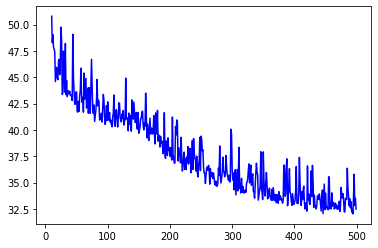

In [29]:
# Plot the result

loss = history.history["loss"]
plot_loss = loss[10:]              # Truncate the first 10 loss
epochs = range(10, len(loss))  
plt.plot(epochs, plot_loss, 'b', label="Training Loss")
plt.show()

In [30]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time+window_size][np.newaxis]))

In [31]:
print(len(forecast))
print(len(x_train))
print(len(x_valid))

1441
1000
461


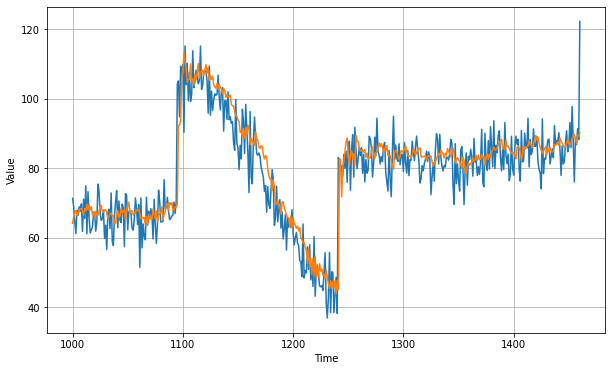

In [32]:
valid_forecast = forecast[split_time - window_size:] # split_time - window_size 번째 input이 들어갔을 때 x_valid의 값을 처음으로 예측한 것이기 때문
results = np.array(valid_forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)